### t2.micro, AWS Marketplace -> Anaconda with Python 3

### 1) Churn

Customers Most Likely To Churn
2103    0.966667
1898    0.933333
502     0.933333
2747    0.933333
117     0.966667
1679    0.966667
2924    1.000000
1078    0.966667
465     0.933333
914     1.000000
2113    1.000000
1934    0.933333
3205    0.966667
2356    0.933333
2099    1.000000
Name: probability_churn, dtype: float64


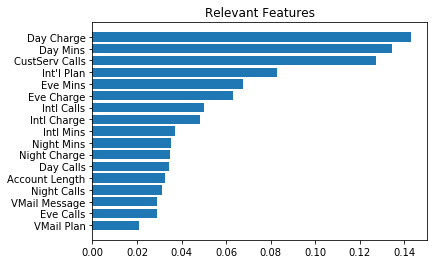

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df                = pd.read_csv('churn.csv').drop(['Phone', 'Area Code', 'State'], axis=1)
features          = df.drop(['Churn'], axis=1).columns
df_train, df_test = train_test_split(df, test_size=0.25)

clf           = RandomForestClassifier(n_estimators=30).fit(df_train[features], df_train['Churn'])
probabilities = clf.predict_proba(df_test[features])

plt.title('Relevant Features')
df_f           = pd.DataFrame(clf.feature_importances_, columns=['importance'])
df_f['labels'] = features
df_f.sort_values('importance', inplace=True, ascending=True)
index          = np.arange(len(clf.feature_importances_))
plt.barh(  index, df_f['importance'])
plt.yticks(index, df_f['labels']    )

print('Customers Most Likely To Churn')
df_copy = df_test.copy()
df_copy['probability_churn'] = probabilities[:, 1]
print(df_copy[df_copy['probability_churn'] > 0.9]['probability_churn'])

### 2) Survival

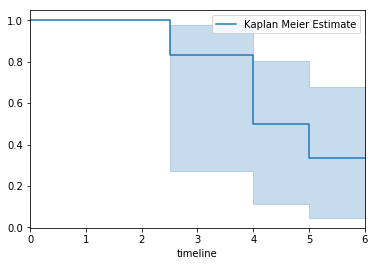

In [2]:
from lifelines import KaplanMeierFitter

durations      = [5, 6, 6, 2.5, 4, 4]
event_observed = [1, 0, 0,   1, 1, 1]

KaplanMeierFitter().fit(durations, event_observed, label='Kaplan Meier Estimate').plot()

### 3) Customer Life-Time Value

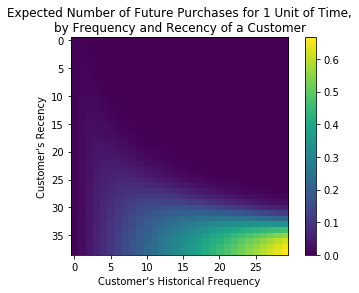

In [2]:
from lifetimes import BetaGeoFitter
from lifetimes.datasets import load_cdnow_summary
from lifetimes.plotting import plot_frequency_recency_matrix

data = load_cdnow_summary()

plot_frequency_recency_matrix(BetaGeoFitter().fit(data['frequency'], data['recency'], data['T']))

### 4) Attribution (Markov Chains)

In [1]:
import numpy as np

I = np.matrix([[1, 0]])
print('Current State: ' + str(I))

T = np.matrix([
               [0.7, 0.3], 
               [0.6, 0.4]
             ])
print('Transition Matrix: ' + str(T))

T1 = I * T
print('After State 1: ' + str(T1))

T2 = T1 * T
print('After State 2: ' + str(T2))

T3 = T2 * T
print('After State 3: ' + str(T3))

Current State: [[1 0]]
Transition Matrix: [[0.7 0.3]
 [0.6 0.4]]
After State 1: [[0.7 0.3]]
After State 2: [[0.67 0.33]]
After State 3: [[0.667 0.333]]


### 5) Causal Inference

INFO:dowhy.do_why:Model to find the causal effect of treatment ['v'] on outcome ['y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'X0']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.


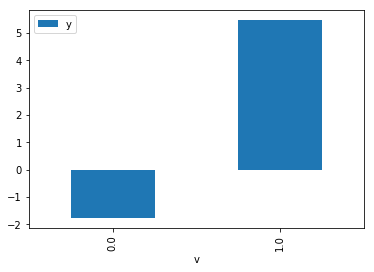

In [3]:
import dowhy.api
import dowhy.datasets

data = dowhy.datasets.linear_dataset(
                                     beta                = 5   ,
                                     num_common_causes   = 1   ,
                                     num_instruments     = 0   ,
                                     num_samples         = 10  ,
                                     treatment_is_binary = True
                                    )

data['df'].causal.do(
                     x              = 'v'                            ,
                     variable_types = {'v': 'b', 'y': 'c', 'X0': 'c'},
                     outcome        = 'y'                            ,
                     common_causes  = ['X0']
                    ).groupby('v').mean().plot(y='y', kind='bar')

### 6) Propensity

In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

prospect_data = pd.read_csv('browsing.csv')

print(prospect_data.corr()['BUY']) # Exclude low correlation columns

predictions_train, predictions_test, target_train, target_test = train_test_split(
    prospect_data[['REVIEWS','BOUGHT_TOGETHER','COMPARE_SIMILAR','WARRANTY','SPONSORED_LINKS']],
    prospect_data.BUY                                                                          ,
    test_size = 0.3                                                              )

clf = GaussianNB().fit(predictions_train, target_train)

print('Prospect buy propensity :'                                  , clf.predict_proba(predictions_test)[0,1])

browsing_data = np.array([0,0,0,0,0]).reshape(1, -1)
print('New visitor buy propensity :'                               , clf.predict_proba(browsing_data)[:,1])

browsing_data = np.array([0,0,1,0,0]).reshape(1, -1)
print('After checking similar products buy propensity :'           , clf.predict_proba(browsing_data)[:,1] )

browsing_data = np.array([1,0,1,0,0]).reshape(1, -1)
print('After checking simlar products and reviews buy propensity :', clf.predict_proba(browsing_data)[:,1] )

SESSION_ID         0.026677
IMAGES             0.046819
REVIEWS            0.404628
FAQ               -0.095136
SPECS              0.009950
SHIPPING          -0.022239
BOUGHT_TOGETHER   -0.103562
COMPARE_SIMILAR    0.190522
VIEW_SIMILAR      -0.096137
WARRANTY           0.179156
SPONSORED_LINKS    0.110328
BUY                1.000000
Name: BUY, dtype: float64
Prospect buy propensity : 0.1774634384126581
New visitor buy propensity : [0.054332]
After checking similar products buy propensity : [0.12657799]
After checking simlar products and reviews buy propensity : [0.58737841]


### 7) Demand Planning

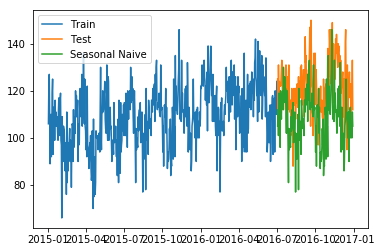

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df         = pd.read_csv('timeseries.csv')
df['date'] = pd.to_datetime(df['date'])

train_count = round(len(df) * 0.75)
train       = df.iloc[:train_count]
test        = df.iloc[train_count + 1:len(df)]

dates                      = (test['date'] - np.timedelta64(1, 'Y')).values.astype('datetime64[D]')
seasonal_naive             = train[train['date'].isin(dates)]['sales'] # seasonal naive prediction
y_hat_sn                   = test.copy().drop('sales', axis=1)
y_hat_sn['seasonal_naive'] = pd.DataFrame(seasonal_naive).set_index(test.index)

plt.plot(   train['date'],    train['sales']         , label='Train'         )
plt.plot(    test['date'],     test['sales']         , label='Test'          )
plt.plot(y_hat_sn['date'], y_hat_sn['seasonal_naive'], label='Seasonal Naive')
plt.legend()

### 8) Forecasting

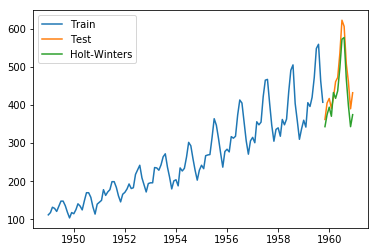

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df = pd.read_csv(
                 'international-airline-passengers.csv', 
                 parse_dates = ['Month'], 
                 index_col   = 'Month'
                )
df.index.freq = 'MS'

train = df.iloc[:130, 0]
test  = df.iloc[130:, 0]

model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
pred  = model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index , test,  label='Test')
plt.plot(pred.index , pred,  label='Holt-Winters')
plt.legend()

### 9) Anomaly Detection

Number of Errors :  Angle-based Outlier Detector (ABOD) 15
Number of Errors :  K Nearest Neighbors (KNN) 5


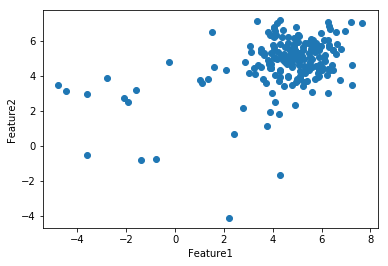

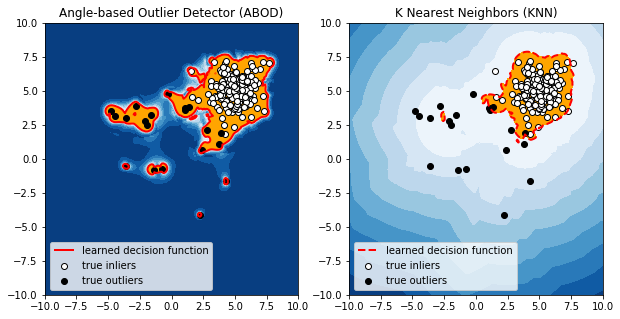

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import get_outliers_inliers

X_train, Y_train = generate_data(n_train=200, train_only=True)
Feature1         = X_train[:,[0]].reshape(-1,1)
Feature2         = X_train[:,[1]].reshape(-1,1)

outlier_fraction      = 0.1
x_outliers, x_inliers = get_outliers_inliers(X_train, Y_train)
n_outliers            = len(x_outliers)

plt.scatter(Feature1, Feature2)
plt.xlabel('Feature1')
plt.ylabel('Feature2')

classifiers = {
               'Angle-based Outlier Detector (ABOD)' : ABOD(contamination = outlier_fraction),
               'K Nearest Neighbors (KNN)'           : KNN( contamination = outlier_fraction)
              }

plt.figure(figsize=(10, 5))
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()) :

  clf.fit(X_train)
  y_pred      = clf.predict(X_train)
  print('Number of Errors : ', clf_name, (y_pred != Y_train).sum())
  scores_pred = clf.decision_function(X_train)*-1
  threshold   = stats.scoreatpercentile(scores_pred, 100*outlier_fraction)

  subplot = plt.subplot(1, 2, i + 1)
  Z       = (clf.decision_function(np.c_[xx.ravel(), yy.ravel()])*-1).reshape(xx.shape)
  subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10), cmap=plt.cm.Blues_r)
  subplot.contourf(xx, yy, Z, levels = [threshold, Z.max()], colors='orange')

  a = subplot.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
  b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white', edgecolor='k') 
  c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black', edgecolor='k')

  subplot.set_title(clf_name)
  subplot.legend(
                 [a.collections[0], b, c],
                 ['learned decision function', 'true inliers', 'true outliers']
                )

### 10) Splines

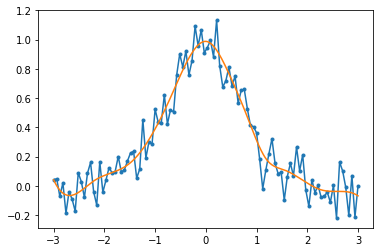

In [2]:
from numpy import exp
from numpy import linspace
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

x  = linspace(-3, 3, 100)
y  = exp(-x**2) + randn(100)/10
s  = UnivariateSpline(x, y, s=1)
xs = linspace(-3, 3, 1000)
ys = s(xs)

plt.plot(x, y, '.-')
plt.plot(xs, ys)